In [1]:
import cobra 
from pytfa.thermo.equilibrator import build_thermo_from_equilibrator,compute_dGf,compound_to_entry
import equilibrator_cache
from cobra import Model, Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import straindesign as sd
from equilibrator_api import ComponentContribution,Q_
import os
import pytfa as tfa
from optlang.exceptions import SolverError
from cobra.flux_analysis import flux_variability_analysis
from cobra.io import load_matlab_model, load_json_model,load_model
from pytfa.io import import_matlab_model, load_thermoDB,                    \
                            read_lexicon, annotate_from_lexicon,            \
                            read_compartment_data, apply_compartment_data
from pytfa.optim.variables import LogConcentration, \
    ThermoDisplacement,DeltaG
from pytfa.analysis.sampling import sample
from pytfa.optim.utils import strip_from_integer_variables
from pytfa.analysis.variability import variability_analysis
from pytfa.analysis import apply_reaction_variability, apply_generic_variability
from pytfa.thermo.equilibrator import build_thermo_from_equilibrator,compute_dGf,compound_to_entry

Fragments already downloaded
Fragments already downloaded


## Load cobra model and heterologous reaction file

In [2]:
model = load_model("textbook")
reactions=pd.read_csv('reactions.csv',header=0,index_col=0)

## Create Thermo model

In [12]:
thermo_data = load_thermoDB('./pytfa/data/thermo_data.thermodb')
EPSILON = 1e-9
tmodel=tfa.ThermoModel(thermo_data,model)
lexicon = read_lexicon('lexicon.csv')
compartment_data = read_compartment_data('compartment_data.json')
annotate_from_lexicon(tmodel, lexicon)
apply_compartment_data(tmodel, compartment_data)
tmodel.prepare()
tmodel.convert(add_displacement=True)

2023-10-03 11:55:50,987 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2023-10-03 11:55:51,008 - thermomodel_None - WARNING - acon_C_c  not found in annotations
2023-10-03 11:55:51,009 - thermomodel_None - WARNING - fru_e  not found in annotations
2023-10-03 11:55:51,011 - thermomodel_None - WARNING - fum_e  not found in annotations
2023-10-03 11:55:51,012 - thermomodel_None - WARNING - glc__D_e  not found in annotations
2023-10-03 11:55:51,014 - thermomodel_None - WARNING - gln__L_c  not found in annotations
2023-10-03 11:55:51,016 - thermomodel_None - WARNING - gln__L_e  not found in annotations
2023-10-03 11:55:51,017 - thermomodel_None - WARNING - glu__L_c  not found in annotations
2023-10-03 11:55:51,018 - thermomodel_None - WARNING - glu__L_e  not found in annotations
2023-10-03 11:55:51,019 - thermomodel_None - WARNING - lac__D_c  not found in annotations
2023-10-03 11:55:51,021 - thermomodel_None - WARNING - lac__D_e  not found in a

2023-09-29 12:00:45,001 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


## Model description

In [5]:
print("Reactions:")
for reaction in model.reactions:
    print(reaction.id, reaction.reaction)


print("Objective value:", solution.objective_value)

Reactions:
PFK atp_c + f6p_c --> adp_c + fdp_c
PFL coa_c + pyr_c --> accoa_c + for_c
PGI g6p_c <=> f6p_c
PGK 3pg_c + atp_c + h_c <=> 13dpg_c + adp_c
PGL 6pgl_c + h2o_c --> 6pgc_c + h_c
ACALD acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
AKGt2r akg_e + h_e <=> akg_c + h_c
PGM 2pg_c <=> 3pg_c
PIt2r h_e + pi_e <=> h_c + pi_c
ALCD2x etoh_c + nad_c <=> acald_c + h_c + nadh_c
ACALDt acald_e <=> acald_c
ACKr ac_c + atp_c + h_c <=> actp_c + adp_c
PPC co2_c + h2o_c + pep_c --> 2.0 h_c + oaa_c + pi_c
ACONTa cit_c <=> acon_C_c + h2o_c
ACONTb acon_C_c + h2o_c <=> icit_c
ATPM atp_c + h2o_c --> adp_c + h_c + pi_c
PPCK atp_c + h_c + oaa_c --> adp_c + co2_c + pep_c
ACt2r ac_e + h_e <=> ac_c + h_c
PPS atp_c + h2o_c + pyr_c --> amp_c + h_c + pep_c + pi_c
ADK1 amp_c + atp_c <=> 2.0 adp_c
AKGDH akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c
ATPS4r adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
PTAr accoa_c + h_c + pi_c <=> actp_c + coa_c
PYK adp_c + pep_c --> atp_c + pyr_c
BIOMASS_Ecoli_core

NameError: name 'solution' is not defined

## Blocked reactions

In [6]:
blocked_reactions=cobra.flux_analysis.find_blocked_reactions(model)
print(blocked_reactions)


['EX_fru_e', 'EX_fum_e', 'EX_gln__L_e', 'EX_mal__L_e', 'FRUpts2', 'FUMt2_2', 'GLNabc', 'MALt2_2']


## IMPOSE ANAEROBIC CONDITIONS


In [5]:
model.reactions.EX_o2_e.bounds=(0,1000)
solution=model.optimize()

## FVA RESULT

In [ ]:
fva_result = cobra.flux_analysis.flux_variability_analysis(model,fraction_of_optimum=0.8)
df=[]
threshold=1

plt.figure(figsize=(10,15))
df=fva_result.drop(['FRD7','SUCDi'], axis='index')
df=df[abs(df['maximum'])>=threshold]
df['mean']=solution.fluxes
x=df.index.map(str)
y=df['mean']
error=[abs(df['minimum'])+df['mean'],abs(df['maximum'])-df['mean']]
plt.tight_layout()
plt.errorbar(y, x, xerr=error, fmt='o', ecolor='red')

plt.legend('FVA RESULTS')
plt.show()
    

## TVA Result

2023-09-29 12:09:09,035 - thermomodel_None - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 72/72 [00:19<00:00,  3.64it/s]
2023-09-29 12:09:45,890 - thermomodel_None - INFO - Beginning variability analysis for variable of type reaction
maximizing: 100%|██████████| 95/95 [00:03<00:00, 28.36it/s]


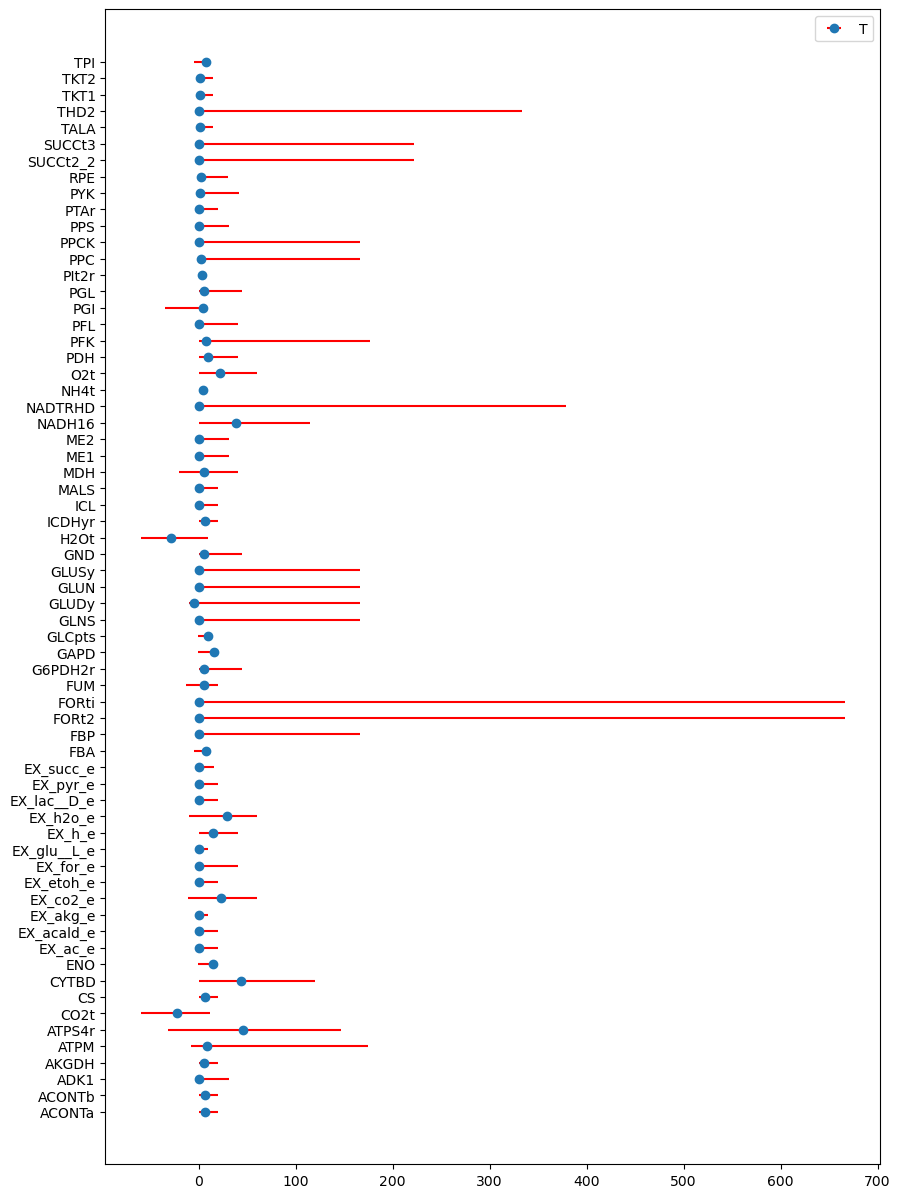

In [6]:
thermo_vars = [LogConcentration]
tva_thermo = variability_analysis(tmodel, kind=thermo_vars)
apply_generic_variability(tmodel, tva_thermo, inplace=True)


solution=tmodel.optimize()
tva_fluxes = variability_analysis(tmodel, kind='reaction')
df=[]
threshold=1

plt.figure(figsize=(10,15))
df=tva_fluxes.drop(['FRD7','SUCDi'], axis='index')
df=df[abs(df['maximum'])>=threshold]
df['mean']=solution.fluxes
x=df.index.map(str)
y=df['mean']
error=[abs(df['minimum'])+df['mean'],abs(df['maximum'])-df['mean']]
plt.tight_layout()
plt.errorbar(y, x, xerr=error, fmt='o', ecolor='red')

plt.legend('TVA RESULTS')
plt.show()


## Add heterologous pathway


In [3]:
model_toy=model
model_toy.solver='cplex'

## Add metabolites

In [4]:
mapping_table=str.maketrans({'-':'','+':'', '>':'','<':''})
metabolites=[]
for i in reactions.index:
    dummy= str(reactions.loc[i]['formula'])
    dummy=dummy.translate(mapping_table)
    dummy=dummy.split()
    for e in dummy:
        if len(e)>2:
            metabolites.append(e)

metabolites = list(set(metabolites))

for b in metabolites:
    if b not in model_toy.metabolites:
        print(b)
        model_toy.add_metabolites([cobra.Metabolite(b, compartment='c')])

print(metabolites)
model_toy.metabolites.get_by_id('1btol_e').compartment='e'        

3hbcoa_c
ctncoa_c
aacoa_c
btcoa_c
1btol_e
btal_c
1btol_c
['3hbcoa_c', 'nadh_c', 'ctncoa_c', 'coa_c', 'accoa_c', 'aacoa_c', 'h_c', 'btcoa_c', '1btol_e', 'btal_c', 'nad_c', 'h2o_c', '1btol_c']


In [5]:
model_toy.metabolites.get_by_id('ctncoa_c').annotation= { 'SeedID': 'cpd00650', 'KeggID': 'C00877'}
model_toy.metabolites.get_by_id('1btol_e').annotation= { 'SeedID': 'cpd03662','KeggID': 'C06142' }
model_toy.metabolites.get_by_id('1btol_c').annotation= { 'SeedID': 'cpd03662','KeggID': 'C06142'}
model_toy.metabolites.get_by_id('3hbcoa_c').annotation= { 'SeedID': 'cpd00842','KeggID': 'C01144'}
model_toy.metabolites.get_by_id('btal_c').annotation= { 'SeedID': 'cpd01011','KeggID': 'C01412'}
model_toy.metabolites.get_by_id('btcoa_c').annotation= { 'SeedID': 'cpd00120','KeggID': 'C00136'}
model_toy.metabolites.get_by_id('aacoa_c').annotation= { 'SeedID': 'cpd00279','KeggID': 'C00332'}

## Add reactions

In [6]:
for i in reactions.index:
    reac=i
    reac=cobra.Reaction(i)
    model_toy.add_reactions([reac])
    reac.reaction= str(reactions.loc[i]['formula'])
    

## Create Thermo model


In [7]:
thermo_data = load_thermoDB('./pytfa/data/thermo_data.thermodb')
EPSILON = 1e-9
tmodel=tfa.ThermoModel(thermo_data,model_toy)
lexicon = read_lexicon('lexicon.csv')
compartment_data = read_compartment_data('compartment_data.json')
annotate_from_lexicon(tmodel, lexicon)
apply_compartment_data(tmodel, compartment_data)
tmodel.prepare()
tmodel.convert(add_displacement=True)
model_toy=tmodel
print("Reactions:")
for reaction in model_toy.reactions:
    print(reaction.id, reaction.reaction)

solution = model_toy.optimize()
print("Objective value:", solution.objective_value)


2023-10-02 13:39:10,464 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2023-10-02 13:39:10,471 - thermomodel_None - WARNING - acon_C_c  not found in annotations
2023-10-02 13:39:10,472 - thermomodel_None - WARNING - fru_e  not found in annotations
2023-10-02 13:39:10,473 - thermomodel_None - WARNING - fum_e  not found in annotations
2023-10-02 13:39:10,475 - thermomodel_None - WARNING - glc__D_e  not found in annotations
2023-10-02 13:39:10,477 - thermomodel_None - WARNING - gln__L_c  not found in annotations
2023-10-02 13:39:10,506 - thermomodel_None - WARNING - gln__L_e  not found in annotations
2023-10-02 13:39:10,507 - thermomodel_None - WARNING - glu__L_c  not found in annotations
2023-10-02 13:39:10,508 - thermomodel_None - WARNING - glu__L_e  not found in annotations
2023-10-02 13:39:10,509 - thermomodel_None - WARNING - lac__D_c  not found in annotations
2023-10-02 13:39:10,510 - thermomodel_None - WARNING - lac__D_e  not found in a

Reactions:
ACALD acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
ACALDt acald_e <=> acald_c
ACKr ac_c + atp_c + h_c <=> actp_c + adp_c
ACONTa cit_c <=> acon_C_c + h2o_c
ACONTb acon_C_c + h2o_c <=> icit_c
ACt2r ac_e + h_e <=> ac_c + h_c
ADK1 amp_c + atp_c <=> 2.0 adp_c
AKGDH akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c
AKGt2r akg_e + h_e <=> akg_c + h_c
ALCD2x etoh_c + nad_c <=> acald_c + h_c + nadh_c
ATPM atp_c + h2o_c --> adp_c + h_c + pi_c
ATPS4r adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
Biomass_Ecoli_core 1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
CO2t co2_e <=> co2_c
CS accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c
CYTBD 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 

## Theoretical yield

In [8]:
model_toy.reactions.EX_o2_e.bounds=(0,1000)
model_toy.objective='EX_1btol'
solution=model_toy.optimize()
the_yield="{:.0%}".format(solution.objective_value/abs(model_toy.reactions.EX_glc__D_e.lower_bound))
print('The theoretical yield', the_yield)
model_toy.objective='Biomass_Ecoli_core'
solution=model_toy.optimize()
print(solution)

The theoretical yield 100%
<Solution 0.214 at 0x22c90f3bd90>


## TVA result with 80% biomass


In [11]:
#fva_result= cobra.flux_analysis.flux_variability_analysis(model_toy,fraction_of_optimum=0.8)
#max_flux=fva_result.loc['EX_1btol'].maximum
#max_yield="{:.0%}".format(max_flux/abs(model_toy.reactions.EX_glc__D_e.lower_bound))
#print('The maximum flux for 80% biomass production is',"%.2f" %max_flux, 'and the achieved yield is',max_yield)

2023-10-02 12:42:37,541 - thermomodel_None - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 79/79 [00:00<00:00, 116.61it/s]
2023-10-02 12:42:38,692 - thermomodel_None - INFO - Beginning variability analysis for variable of type reaction
maximizing: 100%|██████████| 103/103 [00:01<00:00, 97.87it/s]


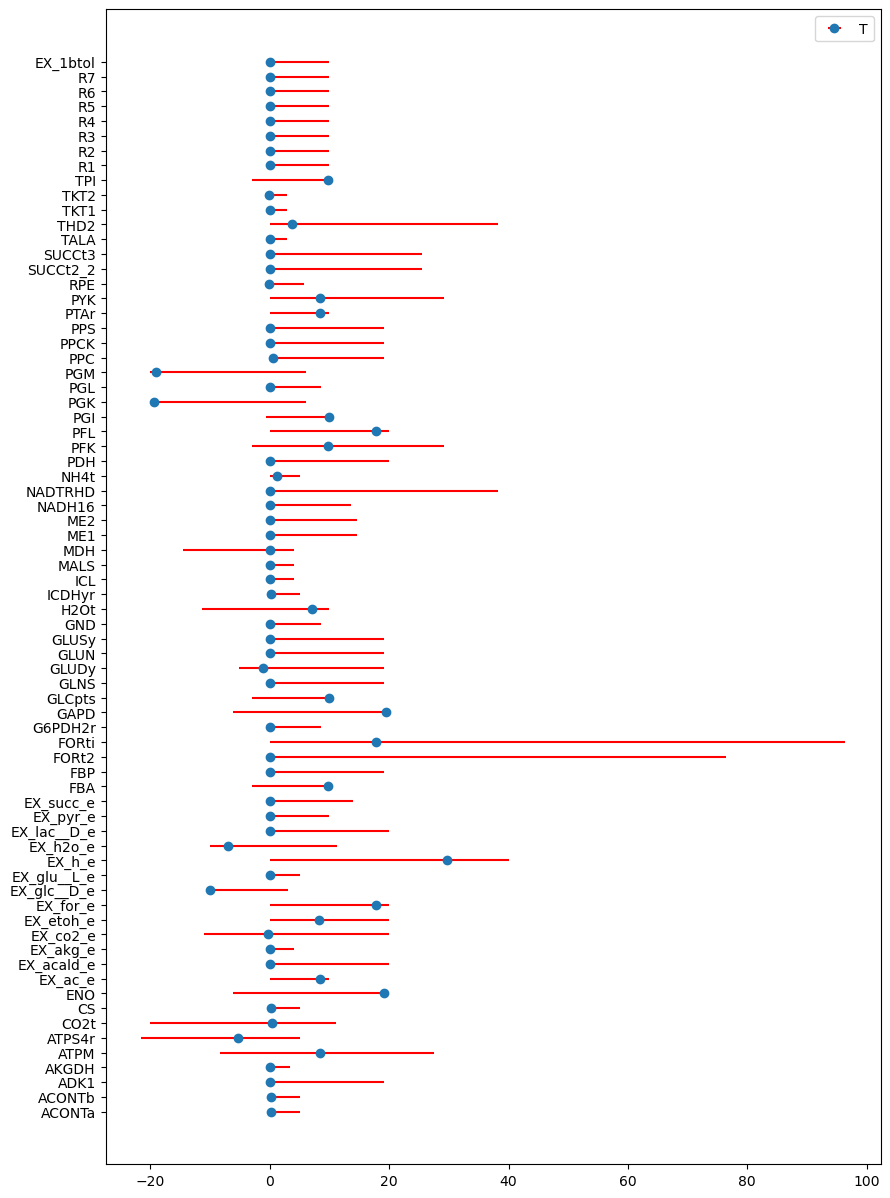

In [9]:
thermo_vars = [LogConcentration]
tva_thermo = variability_analysis(model_toy, kind=thermo_vars)
apply_generic_variability(model_toy, tva_thermo, inplace=True)


solution=model_toy.optimize()
tva_fluxes = variability_analysis(model_toy, kind='reaction')
df=[]
threshold=1

plt.figure(figsize=(10,15))
df=tva_fluxes.drop(['FRD7','SUCDi'], axis='index')
df=df[abs(df['maximum'])>=threshold]
df['mean']=solution.fluxes
x=df.index.map(str)
y=df['mean']
error=[abs(df['minimum'].values)+df['mean'].values,abs(df['maximum'].values)-df['mean'].values]
plt.tight_layout()
plt.errorbar(y, x, xerr=error, fmt='o', ecolor='red')

plt.legend('TVA RESULTS')
plt.show()

## Optknock 

In [26]:
module_optknock = sd.SDModule(model_toy,sd.names.OPTKNOCK,
                              inner_objective='Biomass_Ecoli_core',
                              outer_objective='EX_1btol',
                              constraints='Biomass_Ecoli_core>= 0.20')

In [27]:
import logging
logging.basicConfig(level=logging.INFO)
## Compute strain designs
# allow all gene knockouts except for spontanuos
gko_cost = {g.name:1 for g in model_toy.genes}
#gko_cost.pop('s0001')

# possible knockout of O2

# addition candidates

sols = sd.compute_strain_designs(model_toy,
                                 sd_modules = module_optknock,
                                 max_solutions = 1,
                                 max_cost = 5,
                                 #gko_cost = gko_cost,
                                
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using cplex for solving LPs during preprocessing.


KeyboardInterrupt: 

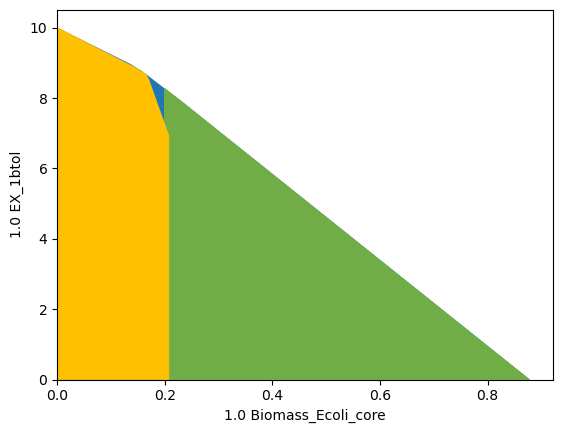

In [21]:
plt.clf()
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(model_toy,
                                               ('Biomass_Ecoli_core','EX_1btol'),
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(model_toy,
                                               ('Biomass_Ecoli_core','EX_1btol'),
                                               constraints='Biomass_Ecoli_core>=0.2',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(model_toy,
                                               ('Biomass_Ecoli_core','EX_1btol'),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [66]:
model_toy.optimize()

,fluxes,reduced_costs
PFK,9.717846,2.602085e-18
PFL,17.057965,0.000000e+00
PGI,9.941850,0.000000e+00
PGK,-19.245954,-0.000000e+00
PGL,0.000000,0.000000e+00
...,...,...
R4,0.000000,0.000000e+00
R5,0.000000,-1.107603e-02
R6,0.000000,0.000000e+00
R7,0.000000,0.000000e+00


In [91]:
model_toy.reactions.CS.bounds=(0,1000)
model_toy.reactions.ALCD2x.bounds=(-1000,1000)
model_toy.reactions.ACALD.bounds=(0,0)
model_toy.optimize()


,fluxes,reduced_costs
PFK,9.812788,1.734723e-18
PFL,18.047932,0.000000e+00
PGI,9.961417,0.000000e+00
PGK,-19.499684,-0.000000e+00
PGL,0.000000,0.000000e+00
...,...,...
R4,4.235052,0.000000e+00
R5,4.235052,0.000000e+00
R6,4.235052,0.000000e+00
R7,4.235052,0.000000e+00


In [4]:
ecc = cobra.io.load_model('e_coli_core')
model_toy=ecc.copy()

In [17]:
# Create copy of model to which pathway will be added
ecc_14bdo = ecc.copy()

# Add metabolites to model
ecc_14bdo.add_metabolites([ cobra.Metabolite('sucsal_c'),# Succinic semialdehyde
                            cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
SSCOARx    = cobra.Reaction('SSCOARx')
AKGDC      = cobra.Reaction('AKGDC')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ecc_14bdo.add_reactions([SSCOARx,
                         AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
AKGDC.reaction      = '1 akg_c + 1 h_c -> 1 co2_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# Verify that pathway is operational
sol = sd.fba(ecc_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Maximum possible 1,4-BDO synthesis rate: 10.252923076923619.


In [18]:
module_optknock = sd.SDModule(ecc_14bdo,sd.names.OPTKNOCK,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM',
                              outer_objective='EX_14bdo_e',
                              constraints='BIOMASS_Ecoli_core_w_GAM >= 0.5')

In [19]:
import logging
logging.basicConfig(level=logging.INFO)
## Compute strain designs
# allow all gene knockouts except for spontanuos
gko_cost = {g.name:1 for g in ecc_14bdo.genes}
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_optknock,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 86 genes and 49 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (267 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 149 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 128 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 122 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 121 rea

One compressed solution with cost 14.0 found and expanded to 8 solutions in the uncompressed netork.
Example intervention set: ['+SSCOARx', '-pgi', '-kgtP', '-gdhA', '-mdh', '-frdD', '-maeA', '-maeB', '-purT', '-ackA', '-tdcD', '-pykF', '-pykA', '-sucC']


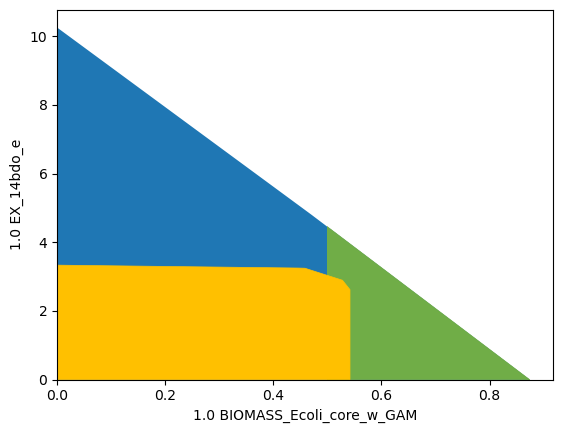

In [20]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.5',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [28]:
sols.get_gene_reac_sd_assoc()

([{'THD2': -1.0, 'PGL': -1.0, 'PPS': -1.0, 'MDH': -1.0},
  {'THD2': -1.0, 'GND': -1.0, 'PPS': -1.0, 'MDH': -1.0}],
 [0, 0, 1, 1],
 [{'mdh': -1.0, 'pgl': -1.0, 'ppsA': -1.0, 'pntB': -1.0},
  {'mdh': -1.0, 'pgl': -1.0, 'ppsA': -1.0, 'pntA': -1.0},
  {'mdh': -1.0, 'gnd': -1.0, 'ppsA': -1.0, 'pntB': -1.0},
  {'mdh': -1.0, 'gnd': -1.0, 'ppsA': -1.0, 'pntA': -1.0}])

In [46]:
model_toy.reactions.MDH.knock_out()
print(model_toy.optimize())
fva_result = cobra.flux_analysis.flux_variability_analysis(model_toy,fraction_of_optimum=0.8)
max_flux=fva_result.loc['EX_1btol'].maximum
max_yield="{:.0%}".format(max_flux/abs(model_toy.reactions.EX_glc__D_e.lower_bound))
print('The maximum flux for 80% biomass production is',"%.2f" %max_flux, 'and the achieved yield is',max_yield)

<Solution 0.621 at 0x2c96cec6f70>
The maximum flux for 80% biomass production is 4.10 and the achieved yield is 41%


In [61]:
model_toy.optimize()

,fluxes,reduced_costs
PFK,9.382636,0.000000
PFL,0.000000,0.000000
PGI,9.872766,0.000000
PGK,-18.350117,-0.000000
PGL,0.000000,0.082754
...,...,...
R4,2.623052,0.000000
R5,2.623052,0.000000
R6,2.623052,0.000000
R7,2.623052,0.000000


In [58]:
sols.

[{'mdh': -1.0, 'pgl': -1.0, 'ppsA': -1.0, 'pntB': -1.0},
 {'mdh': -1.0, 'pgl': -1.0, 'ppsA': -1.0, 'pntA': -1.0},
 {'mdh': -1.0, 'gnd': -1.0, 'ppsA': -1.0, 'pntB': -1.0},
 {'mdh': -1.0, 'gnd': -1.0, 'ppsA': -1.0, 'pntA': -1.0}]

In [59]:
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]

[[{'THD2': 1.0}, '=', 0.0],
 [{'PGL': 1.0}, '=', 0.0],
 [{'PPS': 1.0}, '=', 0.0],
 [{'MDH': 1.0}, '=', 0.0]]

In [83]:
model_toy.optimize()

,fluxes,reduced_costs
PFK,7.477382,1.084202e-18
PFL,0.000000,-1.527746e-02
PGI,4.860861,0.000000e+00
PGK,-16.023526,-2.602085e-18
PGL,4.959985,0.000000e+00
...,...,...
R4,0.000000,0.000000e+00
R5,0.000000,-1.629595e-01
R6,0.000000,0.000000e+00
R7,0.000000,0.000000e+00


In [9]:
tmodel.metabolites.btcoa_c

Metabolite identifier,btcoa_c
Name,
Memory address,0x238881e9bb0
Formula,None
Compartment,None
In 2 reaction(s),"R5, R4"


In [29]:
import sympy

In [30]:
sympy.numbered_symbols

<function sympy.utilities.iterables.numbered_symbols(prefix='x', cls=None, start=0, exclude=(), *args, **assumptions)>

In [13]:
tmodel.reactions.R1.thermo

{'isTrans': False, 'computed': False, 'deltaGR': 1000.0, 'deltaGRerr': 1000.0}

In [27]:
thermo_data

{'name': 'DB_AlbertyUpdate',
 'units': 'kcal/mol',
 'metabolites': {'cpd00805': {'pKa': [1.78, 6.77, 10.75, 13.08, 14.22, 14.87],
   'deltaGf_err': 1.3115,
   'mass_std': 259.0,
   'struct_cues': {'RWOW': 1,
    'Origin': 1,
    'WCH2W': 2,
    'prim_phos': 1,
    'RWWCWW': 1,
    'PrimOH': 4,
    'RWCHWW': 3},
   'id': 'cpd00805',
   'nH_std': 12,
   'name': 'D-Tagatose 6-phosphate',
   'formula': 'C6H12O9P',
   'deltaGf_std': -431.67,
   'error': 'Nil',
   'charge_std': -1,
   'other_names': ['D-Tagatose 6-phosphate', 'D-tagatose 6-phosphate']},
  'cpd11364': {'pKa': [9.5, 14.05, 14.45, 14.74, 15.0, 15.3],
   'deltaGf_err': 5.2647,
   'mass_std': 756.0,
   'struct_cues': {'RWWNW': 1,
    'BWWCdblW': 2,
    'WWCHW': 7,
    'WCH3': 5,
    'WNHW': 5,
    'WNH2': 1,
    'RWCHWW': 2,
    'WNdblW': 1,
    'WCHdblW': 1,
    'amide': 7,
    'Origin': 1,
    'WketoneW': 7,
    'WCH2W': 7,
    'RWCH2W': 2,
    'BWCHdblW': 4,
    'PrimOH': 2},
   'id': 'cpd11364',
   'nH_std': 56,
   'name': 'N

Reaction identifier,EX_1btol
Name,
Memory address,0x1838f0205b0
Stoichiometry,1btol_e --> -->
GPR,
Lower bound,0
Upper bound,1000.0


TypeError: sequence item 0: expected str instance, dict found

<Model e_coli_core at 0x1b37779dcd0>

In [28]:
tmodel.reactions.R1.thermo

{'isTrans': False, 'computed': False, 'deltaGR': 1000.0, 'deltaGRerr': 1000.0}

In [49]:
model_toy.metabolites.ctncoa_c.annotation['KeggID']

'C00877'

In [51]:
build_thermo_from_equilibrator(model_toy)

NameError: name 'create_compound_cache_from_quilt' is not defined

In [52]:
tmodel.reactions.R1.

{'name': 'DB_AlbertyUpdate',
 'units': 'kcal/mol',
 'metabolites': {'cpd00805': {'pKa': [1.78, 6.77, 10.75, 13.08, 14.22, 14.87],
   'deltaGf_err': 1.3115,
   'mass_std': 259.0,
   'struct_cues': {'RWOW': 1,
    'Origin': 1,
    'WCH2W': 2,
    'prim_phos': 1,
    'RWWCWW': 1,
    'PrimOH': 4,
    'RWCHWW': 3},
   'id': 'cpd00805',
   'nH_std': 12,
   'name': 'D-Tagatose 6-phosphate',
   'formula': 'C6H12O9P',
   'deltaGf_std': -431.67,
   'error': 'Nil',
   'charge_std': -1,
   'other_names': ['D-Tagatose 6-phosphate', 'D-tagatose 6-phosphate']},
  'cpd11364': {'pKa': [9.5, 14.05, 14.45, 14.74, 15.0, 15.3],
   'deltaGf_err': 5.2647,
   'mass_std': 756.0,
   'struct_cues': {'RWWNW': 1,
    'BWWCdblW': 2,
    'WWCHW': 7,
    'WCH3': 5,
    'WNHW': 5,
    'WNH2': 1,
    'RWCHWW': 2,
    'WNdblW': 1,
    'WCHdblW': 1,
    'amide': 7,
    'Origin': 1,
    'WketoneW': 7,
    'WCH2W': 7,
    'RWCH2W': 2,
    'BWCHdblW': 4,
    'PrimOH': 2},
   'id': 'cpd11364',
   'nH_std': 56,
   'name': 'N

In [7]:
model_toy

Name,e_coli_core
Memory address,1864f478c70
Number of metabolites,79
Number of reactions,103
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [7]:
toy=build_thermo_from_equilibrator(model_toy)

TypeError: 'module' object is not callable

In [30]:
compute_dGf(model_toy.metabolites.get_by_id('1btol_c').annotation['KeggID'],cc=ComponentContribution())

AttributeError: 'ComponentContribution' object has no attribute 'dG0_prime'

In [29]:
model_toy.metabolites.get_by_id('1btol_c').annotation['KeggID']

'C06142'